In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [50]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [51]:
len(words)

32033

In [52]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [53]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [54]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
# hpreact was taking larger values
# so we have reduced the size of W1 and b1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [55]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3135


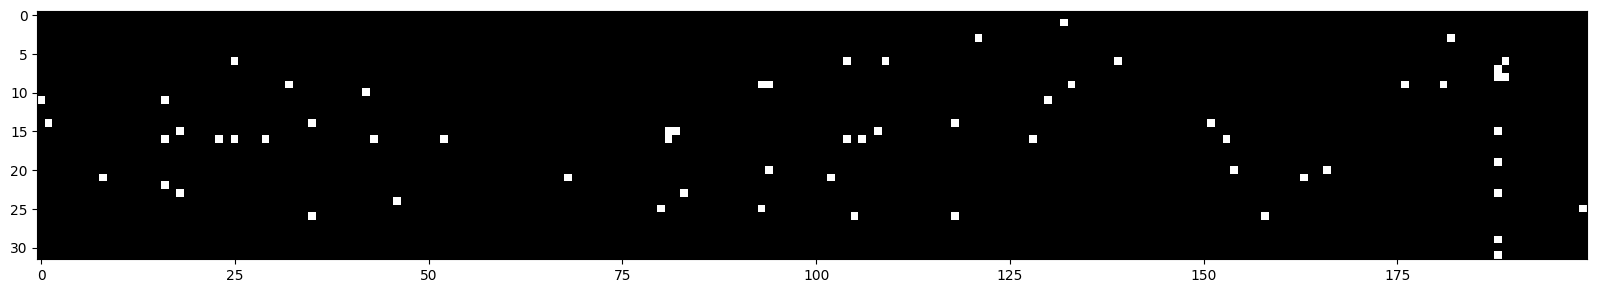

In [56]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [57]:
# now you can see we have less whites

(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

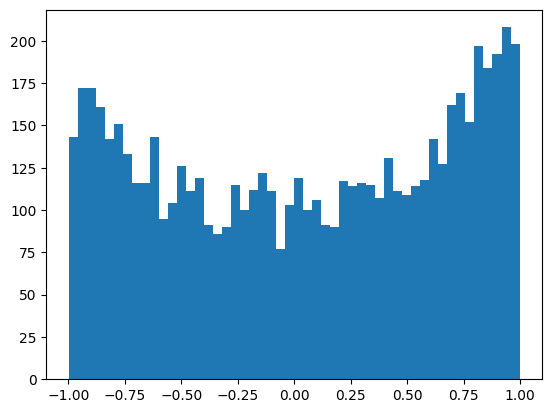

In [58]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367116, -3.6200974 , -3.47652364, -3.33294988, -3.18937612,
        -3.04580235, -2.90222859, -2.75865483, -2.61508107, -2.47150731,
        -2.32793355, -2.18435979, -2.04078603, -1.89721227, -1.75363851,
        -1.61006474, -1.46649098, -1.32291722, -1.17934346, -1.0357697 ,
        -0.89219594, -0.74862218, -0.60504842, -0.46147466, -0.3179009 ,
        -0.17432714, -0.03075337,  0.11282039,  0.25639415,  0.39996791,
         0.54354167,  0.68711543,  0.83068919,  0.97426295,  1.11783671,
         1.26141047,  1.40498424,  1.548558  ,  1.69213176,  1.83570552,
         1.97927928,  2.12285304,  2.2664268 ,  2.41000056,  2.55357432,
 

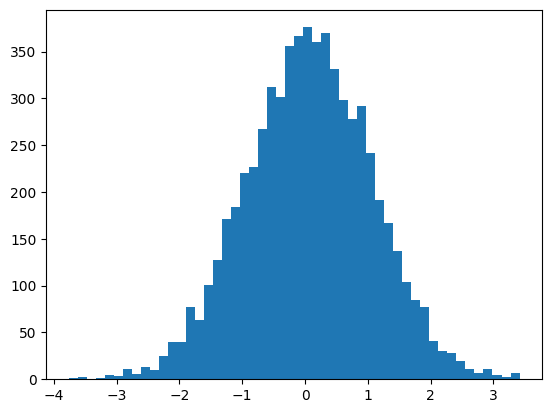

In [59]:
plt.hist(hpreact.view(-1).tolist(), 50)

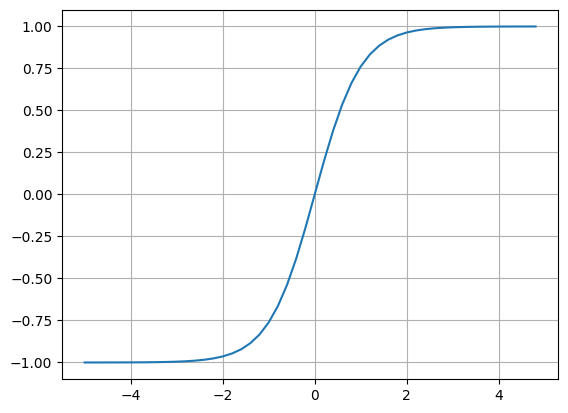

In [60]:
# the graph of tanh
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

plt.grid()

In [61]:
# now we can see hpreact takes values between -3 and 3
# this ensures proper gradients flow

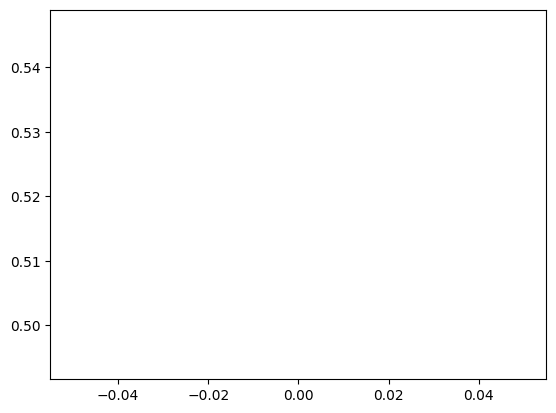

In [62]:
plt.plot(lossi)

In [63]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 3.241575002670288
val 3.241713762283325


In [64]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, n_embed)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtb.
hqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiu.
rrmuqptcmziivduxlhggphhbm.
poin.
qbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojqmwyojsfrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxyh.
xqioloqbplbvbbdn.
ip.
qmuitjpbvfpzpddgpycsislqwkkmcrnzauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyltoorowooktbymouokfbfcw.
zoinhzcs.
au.
eoaignqqeroqci.
